Обучить детектор объектов с помощью TensorFlow Object Detection API
Библиотеки: [Python, Tensorflow]

### Загружаем заранее обученную модель

In [1]:
import tensorflow as tf
import pathlib

MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
TF_MODELS_BASE_PATH = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
CACHE_FOLDER = './cache'

def download_tf_model(model_name, cache_folder):
    model_url = TF_MODELS_BASE_PATH + model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=model_url,
        untar=True,
        cache_dir=pathlib.Path(cache_folder).absolute()
    )
    return model_dir

# Start the model download.
model_dir = download_tf_model(MODEL_NAME, CACHE_FOLDER)
print(model_dir)

20520960/20518283 [==============================] - 4s 0us/step
/tmp\.keras\datasets\ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8


### Загружаем ярлыки COCO

In [2]:
import os

# Import Object Detection API helpers.
from object_detection.utils import label_map_util

# Loads the COCO labels data (class names and indices relations).
def load_coco_labels():
    # Object Detection API already has a complete set of COCO classes defined for us.
    label_map_path = os.path.join(
        'models/research/object_detection/data',
        'mscoco_complete_label_map.pbtxt'
    )
    label_map = label_map_util.load_labelmap(label_map_path)

    # Class ID to Class Name mapping.
    categories = label_map_util.convert_label_map_to_categories(
        label_map,
        max_num_classes=label_map_util.get_max_label_map_index(label_map),
        use_display_name=True
    )
    category_index = label_map_util.create_category_index(categories)

    # Class Name to Class ID mapping.
    label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

    return category_index, label_map_dict

# Load COCO labels.
coco_category_index, coco_label_map_dict = load_coco_labels()

print('coco_category_index:', coco_category_index)
print('coco_label_map_dict:', coco_label_map_dict)


coco_category_index: {1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 12: {'id': 12, 'name': '12'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 26: {'id': 26, 'name': '26'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 29: {'id': 29, 'name': '29'}, 30: {'id': 3

### Создаем функцию обнаружения

In [7]:
import tensorflow as tf

# Import Object Detection API helpers.
from object_detection.utils import config_util
from object_detection.builders import model_builder

# Generates the detection function for specific model and specific model's checkpoint
def detection_fn_from_checkpoint(config_path, checkpoint_path):
    # Build the model.
    pipeline_config = config_util.get_configs_from_pipeline_file(config_path)
    model_config = pipeline_config['model']
    model = model_builder.build(
        model_config=model_config,
        is_training=False,
    )

    # Restore checkpoints.
    ckpt = tf.compat.v2.train.Checkpoint(model=model)
    ckpt.restore(checkpoint_path).expect_partial()

    # This is a function that will do the detection.
    @tf.function
    def detect_fn(image):
        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)

        return detections, prediction_dict, tf.reshape(shapes, [-1])

    return detect_fn

inference_detect_fn = detection_fn_from_checkpoint(
    config_path=os.path.join('C:\\tmp\.keras', 'datasets', MODEL_NAME, 'pipeline.config'),
    checkpoint_path=os.path.join('C:\\tmp\.keras', 'datasets', MODEL_NAME, 'checkpoint', 'ckpt-0'),
)


### Загружаем тестовые изображения

Found 1 files belonging to 1 classes.


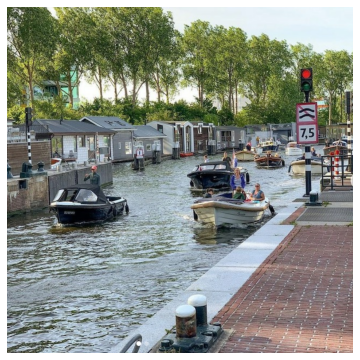

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Creating a TensorFlow dataset of just one image.
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='inference',
  image_size=(640, 640),
  batch_size=1,
  shuffle=False,
  label_mode=None
)
# Numpy version of the dataset.
inference_ds_numpy = list(inference_ds.as_numpy_iterator())

# You may preview the images in dataset like this.
plt.figure(figsize=(14, 14))
for i, image in enumerate(inference_ds_numpy):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image[0].astype("uint8"))
    plt.axis("off")
plt.show()

### Запускаем обнаружение для тестового изображения

In [9]:
detections, predictions_dict, shapes = inference_detect_fn(
    inference_ds_numpy[0]
)

In [10]:
boxes = detections['detection_boxes'].numpy()
scores = detections['detection_scores'].numpy()
classes = detections['detection_classes'].numpy()
num_detections = detections['num_detections'].numpy()[0]

print('boxes.shape: ', boxes.shape)
print('scores.shape: ', scores.shape)
print('classes.shape: ', classes.shape)
print('num_detections:', num_detections)

boxes.shape:  (1, 100, 4)
scores.shape:  (1, 100)
classes.shape:  (1, 100)
num_detections: 100.0


Давайте проверим первые 5 таких "обнаружений":

In [11]:
print('First 5 boxes:')
print(boxes[0,:5])

print('First 5 scores:')
print(scores[0,:5])

print('First 5 classes:')
print(classes[0,:5])

class_names = [coco_category_index[idx + 1]['name'] for idx in classes[0]]
print('First 5 class names:')
print(class_names[:5])

First 5 boxes:
[[0.17576033 0.84654826 0.25642633 0.88327974]
 [0.5187813  0.12410264 0.6344235  0.34545377]
 [0.5220358  0.5181462  0.6329132  0.7669856 ]
 [0.50933677 0.7045719  0.5619138  0.7446198 ]
 [0.44761637 0.51942706 0.61237675 0.75963426]]
First 5 scores:
[0.6950246 0.6343004 0.591157  0.5827219 0.5415643]
First 5 classes:
[9. 8. 8. 0. 8.]
First 5 class names:
['traffic light', 'boat', 'boat', 'person', 'boat']


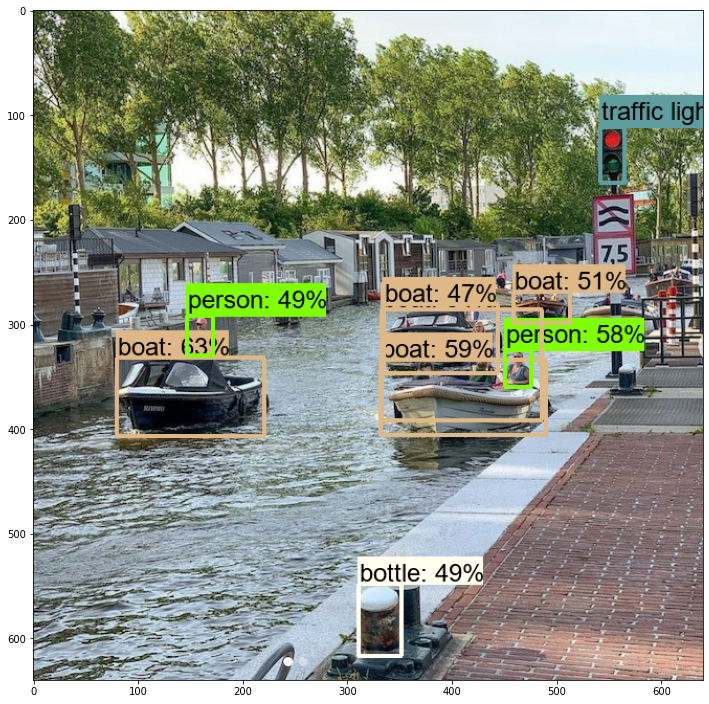

In [12]:
# Importing Object Detection API helpers.
from object_detection.utils import visualization_utils

# Visualizes the bounding boxes on top of the image.
def visualize_detections(image_np, detections, category_index):
    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.4,
        agnostic_mode=False,
    )

    plt.figure(figsize=(12, 16))
    plt.imshow(image_np_with_detections)
    plt.show()

# Visualizing the detections.
visualize_detections(
    image_np=tf.cast(inference_ds_numpy[0][0], dtype=tf.uint32).numpy(),
    detections=detections,
    category_index=coco_category_index,
)


### Подготавливаем набор данных для тренировки

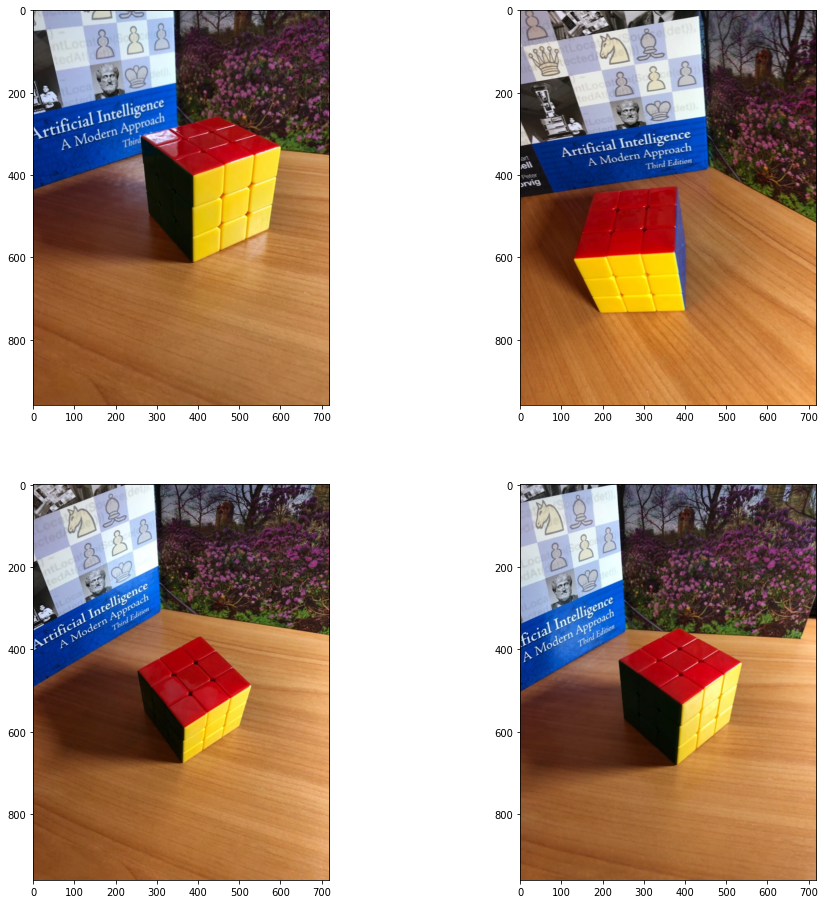

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import shutil

from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance


def preview_images(images_dir, images_num=1, figsize=(15, 15)):
    image_names = os.listdir(images_dir)
    image_names = image_names[:images_num]

    num_cells = math.ceil(math.sqrt(images_num))
    figure = plt.figure(figsize=figsize)

    for image_index, image_name in enumerate(image_names):
        image_path = os.path.join(images_dir, image_name)
        image = Image.open(image_path)

        figure.add_subplot(num_cells, num_cells, image_index + 1)
        plt.imshow(np.asarray(image))

    plt.show()

preview_images('my_data', images_num=4, figsize=(16, 16))


In [49]:
import os
import io
import math
import glob
import tensorflow as tf
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
from collections import namedtuple
from object_detection.utils import dataset_util, label_map_util

tf1 = tf.compat.v1

# Convers labels from XML format to CSV.
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                int(root.find('size')[0].text),
                int(root.find('size')[1].text),
                member[0].text,
                int(member[4][0].text),
                int(member[4][1].text),
                int(member[4][2].text),
                int(member[4][3].text)
            )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

def class_text_to_int(row_label, label_map_dict):
    return label_map_dict[row_label]

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

# Creates a TFRecord.
def create_tf_example(group, path, label_map_dict):
    with tf1.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()

    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class'], label_map_dict))

    tf_example = tf1.train.Example(features=tf1.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))

    return tf_example

def dataset_to_tfrecord(
    images_dir,
    xmls_dir, 
    label_map_path,
    output_path,
    csv_path=None
):
    label_map = label_map_util.load_labelmap(label_map_path)
    label_map_dict = label_map_util.get_label_map_dict(label_map)

    tfrecord_writer = tf1.python_io.TFRecordWriter(output_path)
    images_path = os.path.join(images_dir)
    csv_examples = xml_to_csv(xmls_dir)
    grouped_examples = split(csv_examples, 'filename')

    for group in grouped_examples:
        tf_example = create_tf_example(group, images_path, label_map_dict)
        tfrecord_writer.write(tf_example.SerializeToString())

    tfrecord_writer.close()

    print('Successfully created the TFRecord file: {}'.format(output_path))

    if csv_path is not None:
        csv_examples.to_csv(csv_path, index=None)
        print('Successfully created the CSV file: {}'.format(csv_path))


In [50]:
# Generate a TFRecord for train dataset.
dataset_to_tfrecord(
    images_dir="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\partitioned\\train",
    xmls_dir="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\partitioned\\train",
    label_map_path="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\labels\\label_map.pbtxt",
    output_path="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\tfrecords\\train.record",
    csv_path="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\labels\\csv\\train.csv"
)

Successfully created the TFRecord file: C:\Users\gulch\PycharmProjects\computer_vision\Lesson5\my_data\dataset\tfrecords\train.record
Successfully created the CSV file: C:\Users\gulch\PycharmProjects\computer_vision\Lesson5\my_data\dataset\labels\csv\train.csv


In [51]:
# Generate a TFRecord for test dataset.
dataset_to_tfrecord(
    images_dir="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\partitioned\\test",
    xmls_dir="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\partitioned\\test",
    label_map_path="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\labels\label_map.pbtxt",
    output_path="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\tfrecords\\test.record",
    csv_path="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\Labels\\csv\\test.csv"
)


Successfully created the TFRecord file: C:\Users\gulch\PycharmProjects\computer_vision\Lesson5\my_data\dataset\tfrecords\test.record
Successfully created the CSV file: C:\Users\gulch\PycharmProjects\computer_vision\Lesson5\my_data\dataset\Labels\csv\test.csv


Эти два файла test.record и train.record являются конечной версией нашего набора данных, который мы будем использовать для обучения модели ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.

### Работаем с набором данных в формате TFRecord

In [55]:
PATH = os.path.join("C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\tfrecords")

In [56]:
import tensorflow as tf

# Count the number of examples in the dataset.
def count_tfrecords(tfrecords_filename):
    raw_dataset = tf.data.TFRecordDataset(tfrecords_filename)
    # Keep in mind that the list() operation might be
    # a performance bottleneck for large datasets. 
    return len(list(raw_dataset))

TRAIN_RECORDS_NUM = count_tfrecords(os.path.join(PATH,'train.record'))
TEST_RECORDS_NUM = count_tfrecords(os.path.join(PATH,'test.record'))

print('TRAIN_RECORDS_NUM: ', TRAIN_RECORDS_NUM)
print('TEST_RECORDS_NUM:  ', TEST_RECORDS_NUM)

TRAIN_RECORDS_NUM:  9
TEST_RECORDS_NUM:   2


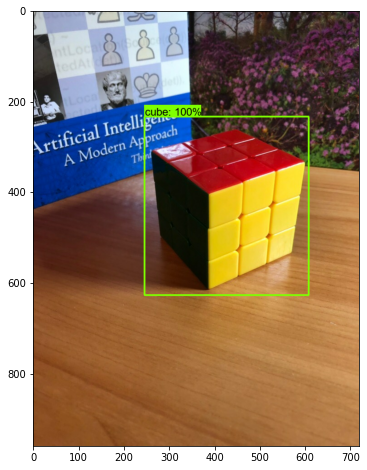

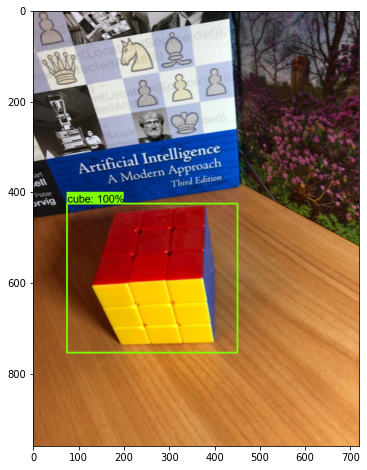

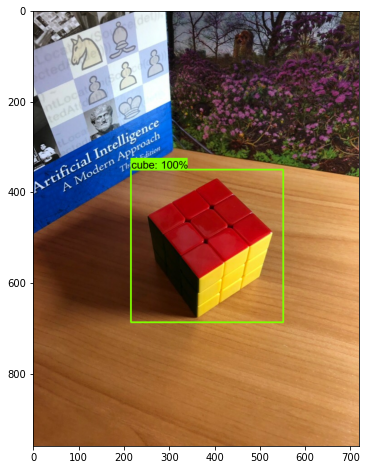

In [57]:
import tensorflow as tf
import numpy as np
from google.protobuf import text_format
import matplotlib.pyplot as plt

# Import Object Detection API.
from object_detection.utils import visualization_utils
from object_detection.protos import string_int_label_map_pb2
from object_detection.data_decoders.tf_example_decoder import TfExampleDecoder

%matplotlib inline

# Visualize the TFRecord dataset.
def visualize_tfrecords(tfrecords_filename, label_map=None, print_num=1):
    decoder = TfExampleDecoder(
        label_map_proto_file=label_map,
        use_display_name=False
    )

    if label_map is not None:
        label_map_proto = string_int_label_map_pb2.StringIntLabelMap()

        with tf.io.gfile.GFile(label_map,'r') as f:
            text_format.Merge(f.read(), label_map_proto)
            class_dict = {}

            for entry in label_map_proto.item:
                class_dict[entry.id] = {'name': entry.name}

    raw_dataset = tf.data.TFRecordDataset(tfrecords_filename)

    for raw_record in raw_dataset.take(print_num):
        example = decoder.decode(raw_record)

        image = example['image'].numpy()
        boxes = example['groundtruth_boxes'].numpy()
        confidences = example['groundtruth_image_confidences']
        filename = example['filename']
        area = example['groundtruth_area']
        classes = example['groundtruth_classes'].numpy()
        image_classes = example['groundtruth_image_classes']
        weights = example['groundtruth_weights']

        scores = np.ones(boxes.shape[0])

        visualization_utils.visualize_boxes_and_labels_on_image_array( 
            image,                                               
            boxes,                                                     
            classes,
            scores,
            class_dict,
            max_boxes_to_draw=None,
            use_normalized_coordinates=True
        )

        plt.figure(figsize=(8, 8))
        plt.imshow(image)

    plt.show()

# Visualizing the training TFRecord dataset.
visualize_tfrecords(
    tfrecords_filename=os.path.join(PATH,'train.record'),
    label_map="C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\labels\label_map.pbtxt",
    print_num=3
)


In [58]:
%load_ext tensorboard

In [59]:
%tensorboard --logdir ./logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 27900.

### Тренировка модели

In [61]:
config_path=os.path.join('C:\\tmp\.keras', 'datasets', MODEL_NAME)
config_path

'C:\\tmp\\.keras\\datasets\\ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'

In [71]:
import tensorflow as tf
from shutil import copyfile
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

# Adjust pipeline config modification here if needed.
def modify_config(pipeline):
    # Model config.
    pipeline.model.ssd.num_classes = 1    

    # Train config.
    pipeline.train_config.batch_size = 9

    pipeline.train_config.fine_tune_checkpoint = os.path.join(config_path,'checkpoint\\ckpt-0')
    pipeline.train_config.fine_tune_checkpoint_type = 'detection'

    # Train input reader config.
    pipeline.train_input_reader.label_map_path = "C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\labels\\label_map.pbtxt"
    pipeline.train_input_reader.tf_record_input_reader.input_path[0] = os.path.join(PATH,'train.record')

    # Eval input reader config.
    pipeline.eval_input_reader[0].label_map_path = "C:\\Users\\gulch\\PycharmProjects\\computer_vision\\Lesson5\\my_data\\dataset\\labels\\label_map.pbtxt"
    pipeline.eval_input_reader[0].tf_record_input_reader.input_path[0] = os.path.join(PATH,'test.record')

    return pipeline

def clone_pipeline_config():
    copyfile(
        os.path.join(config_path,'pipeline.config'),
        'pipeline.config'
    )

def setup_pipeline(pipeline_config_path):
    clone_pipeline_config()
    pipeline = read_pipeline_config(pipeline_config_path)
    pipeline = modify_config(pipeline)
    write_pipeline_config(pipeline_config_path, pipeline)
    return pipeline

def read_pipeline_config(pipeline_config_path):
    pipeline = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          
    with tf.io.gfile.GFile(pipeline_config_path, "r") as f:                                                                                                                                                                                                                     
        proto_str = f.read()                                                                                                                                                                                                                                          
        text_format.Merge(proto_str, pipeline)
    return pipeline

def write_pipeline_config(pipeline_config_path, pipeline):
    config_text = text_format.MessageToString(pipeline)                                                                                                                                                                                                        
    with tf.io.gfile.GFile(pipeline_config_path, "wb") as f:                                                                                                                                                                                                                       
        f.write(config_text)

# Adjusting the pipeline configuration.
pipeline = setup_pipeline('pipeline.config')

print(pipeline)


model {
  ssd {
    num_classes: 1
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 4e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.01
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.997
          scale: true
          epsilon: 0.001
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      arg

### Запускаем процесс тренировки

In [70]:


NUM_TRAIN_STEPS=1000
CHECKPOINT_EVERY_N=1000

PIPELINE_CONFIG_PATH='pipeline.config'
MODEL_DIR='./logs'
SAMPLE_1_OF_N_EVAL_EXAMPLES=1

!python ./models/research/object_detection/model_main_tf2.py \
  --model_dir=$MODEL_DIR \
  --num_train_steps=$NUM_TRAIN_STEPS \
  --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --checkpoint_every_n=$CHECKPOINT_EVERY_N \
  --alsologtostderr


2021-02-16 22:04:27.539234: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-02-16 22:04:30.627855: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-16 22:04:30.628282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-02-16 22:04:30.991047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2060 with Max-Q Design computeCapability: 7.5
coreClock: 1.185GHz coreCount: 30 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 245.91GiB/s
2021-02-16 22:04:30.991071: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-02-16 22:04:30.995163: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas6

In [69]:
!python ./models/research/object_detection/exporter_main_v2.py \
    --input_type=image_tensor \
    --pipeline_config_path=pipeline.config \
    --trained_checkpoint_dir=logs \
    --output_directory=exported/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8


2021-02-16 22:00:48.321168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-02-16 22:00:51.882745: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-16 22:00:51.883385: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-02-16 22:00:52.430456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2060 with Max-Q Design computeCapability: 7.5
coreClock: 1.185GHz coreCount: 30 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 245.91GiB/s
2021-02-16 22:00:52.430489: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-02-16 22:00:52.434607: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas6